## 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
import torch.nn.functional as F # torch 내의 세부적인 기능을 불러온다.
from torch import nn, optim # torch 내의 세부적인 기능을 불러온다. (신경망 기술, 손실함수, 최적화 방법 등)


In [2]:
df = datasets.load_iris()

In [3]:
X = df['data']
Y = df['target']

## 데이터 전처리

### 데이터를 numpy 배열로 만들기

MinMaxScaler로 데이터 스케일링

In [4]:
scaler = MinMaxScaler() 
scaler.fit(X) 
X = scaler.transform(X)

LabelEncoder로 target 전처리

In [5]:
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)
# 타겟 값 one-hot encoding
Y = to_categorical(Y)

### 텐서 데이터와 배치 만들기

#### train test 나누고 각각 tensor 형태로 변환

In [6]:
## 데이터를 tensor 형태로 변환
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.LongTensor(y_data) #multi class label이므로 Long타입으로 변환
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

trainsets = TensorData(X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)

testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)

## 모델 구축

In [8]:
class Model(nn.Module):
    def __init__(self):
        super().__init__() 
        self.fc1 = nn.Linear(4, 50, bias=True) # 입력층(4) -> 은닉층1(50)으로 가는 연산, input=>4
        self.fc2 = nn.Linear(50, 30, bias=True) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
        self.fc3 = nn.Linear(30, 3, bias=True) # 은닉층2(30) -> 출력층(3)으로 가는 연산, output=>3
        self.dropout = nn.Dropout(0.2) 

    def forward(self, x): 
        x = F.relu(self.fc1(x))  
        x = self.dropout(F.relu(self.fc2(x))) 
        x = self.fc3(x)# CrossEntropyLoss는 softmax 계산까지 포함되어 있으므로 모델의 마지막 output node에 별도의 활성화 함수를 사용하지 않아도 된다.  
      
        return x

### 모델, 손실함수, 최적화 방법 선언

In [9]:
model = Model()
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss는 softmax 계산까지 포함되어 있으므로 모델의 마지막 output node에 별도의 활성화 함수를 사용하지 않아도 된다.

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

In [10]:
print(model)

Model(
  (fc1): Linear(in_features=4, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## 모델 학습

In [11]:
loss_ = []
accuracy_ = []
n = len(trainloader)

for epoch in range(400): # 400 epoch 진행

    running_loss, total, correct = 0.0, 0.0, 0.0
    
    for i, data in enumerate(trainloader, 0):

        inputs, values = data 

        optimizer.zero_grad() # 최적화 초기화
        
        outputs = model(inputs) # 모델에 입력값 대입 후 예측값 산출
        loss = criterion(outputs, torch.max(values, dim=1)[1]) # 손실 함수 계산
        loss.backward() # 손실 함수 기준으로 역전파 설정 
        optimizer.step() # 역전파를 진행하고 가중치 업데이트
        
        running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.
        
        _, predicted = torch.max(outputs.data, 1)
        total += values.size(0) # 개수 누적(총 개수)
        correct += (predicted == torch.max(values, dim=1)[1]).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)

    loss_.append(running_loss / n)
    accuracy_.append(100 * correct / total)

print('Finished Training')

Finished Training


### 성능 시각화

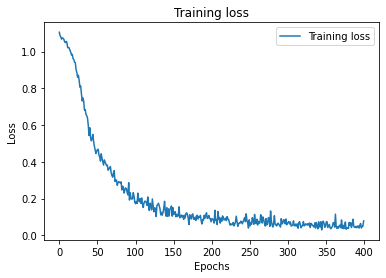

In [13]:
# loss 시각화
plt.plot(loss_, label='Training loss')
plt.title("Training loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

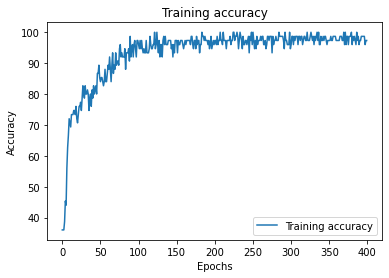

In [14]:
# accuracy 시각화
plt.plot(accuracy_, label='Training accuracy')
plt.title("Training accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## 모델 평가

### 정확도 계산

In [15]:
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in testloader:
        inputs, values = data[0], data[1]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += values.size(0) # 개수 누적(총 개수)
        correct += (predicted == torch.max(values, dim=1)[1]).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)
        
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 94 %
